# Universal Mixtures

In [1]:
using RxInfer, Distributions, Random, Plots

John and Jane are having a coin toss competition. Before they start, they both have the feeling that something is not right. The coin is unbalanced and favors one side over the other. However, both John and Jane do not know which side is being favored. John thinks that the coin favors heads and Jane thinks tails. Coincidentally, both John and Jane have a strong mathematics background and are aware of the appropriate likelihood function for this experiment

$$p(y_i \mid \theta) = \mathrm{Ber}(y_i \mid \theta),$$

where $y_i \in \{0,1\}$ are the outcomes of the coin tosses, i.e. heads or tails, and where $\theta$ is the coin parameter.
They express their gut feeling about the fairness of the coin in terms of a prior distribution over the coin parameter $\theta$, which represents the probability of the coin landing on heads. Based on their gut feeling and the support of $\theta\in[0,1]$ they come up with the prior beliefs:

$$p(\theta \mid \text{John}) = \mathrm{Beta}(\theta \mid 7, 2)$$
$$p(\theta \mid \text{Jane}) = \mathrm{Beta}(\theta \mid 2, 7)$$

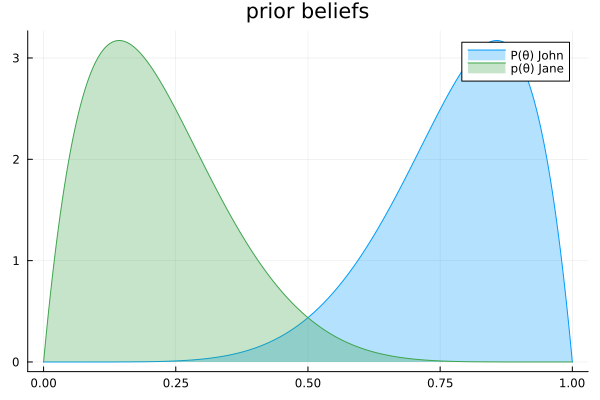

In [2]:
rθ = range(0, 1, length = 1000)
p = plot(title = "prior beliefs")
plot!(rθ, (x) -> pdf(Beta(7.0, 2.0), x), fillalpha=0.3, fillrange = 0, label="P(θ) John", c=1)
plot!(rθ, (x) -> pdf(Beta(2.0, 7.0), x), fillalpha=0.3, fillrange = 0, label="p(θ) Jane", c=3,)

John and Jane really want to clear the odds and decide to perform a lengthy experiment. They toss the unbalanced coin N = 10 times, because their favorite TV show is cancelled anyway and therefore they have plenty of time. 

In [3]:
true_coin = Bernoulli(0.25)
nr_throws = 10
dataset = Int.(rand(MersenneTwister(42), true_coin, nr_throws))
nr_heads, nr_tails = sum(dataset), nr_throws-sum(dataset)
println("experimental outcome: \n - heads: ", nr_heads, "\n - tails: ", nr_tails);

experimental outcome: 
 - heads: 5
 - tails: 5


For computing the posterior beliefs $p(\theta \mid y)$ about the parameter $\theta$, they will perform probabilistic inference in the model based on Bayes' rule. Luckily everything is tractable and therefore they can resort to exact inference. They decide to outsource these tedious computations using `RxInfer.jl` and specify the following models:

### John's model:

$$p(y, \theta \mid \text{John}) = p(\theta \mid \text{John}) \prod_{i=1}^N p(y_i \mid \theta)$$ 

In [4]:
@model function beta_model_john(y)

    # specify John's prior model over θ
    θ ~ Beta(7.0, 2.0)

    # create likelihood models
    y .~ Bernoulli(θ)
    
end

### Jane's model:

$$p(y, \theta \mid \text{Jane}) = p(\theta \mid \text{Jane}) \prod_{i=1}^N p(y_i \mid \theta)$$ 

In [5]:
@model function beta_model_jane(y)

    # specify Jane's prior model over θ
    θ ~ Beta(2.0, 7.0)

    # create likelihood models
    y .~ Bernoulli(θ)
    
end

Now it is time to figure out whose prior belief was the best and who was actually right. They perform probabilistic inference automatically and compute the Bethe free energy to compare eachothers models. For acyclic models, the Bethe free energy $\mathrm{F}_B$ bounds the model evidence $p(y)$ as 

$$\mathrm{F}_B[p,q] \geq - \ln p(y)$$

In [6]:
result_john = infer(
    model = beta_model_john(), 
    data  = (y = dataset, ),
    free_energy = true,
)

Inference results:
  Posteriors       | available for (θ)
  Free Energy:     | Real[8.28853]


In [7]:
result_jane = infer(
    model = beta_model_jane(), 
    data  = (y = dataset, ),
    free_energy = true
)

Inference results:
  Posteriors       | available for (θ)
  Free Energy:     | Real[8.28853]


From these results, they agree that Jane her gut feeling was right all along, as her Bethe free energy is lower and therefore her model evidence is higher. Nonetheless, after the 10 throws, they now have a better idea about the underlying $\theta$ parameter. They formulate this through the posterior distributions $p(\theta \mid y, \text{John})$ and $p(\theta \mid y, \text{Jane})$:

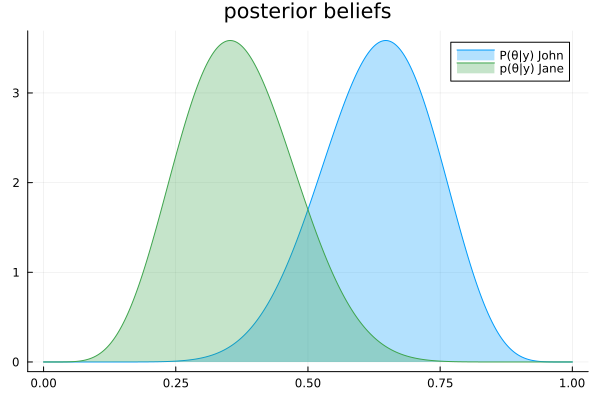

In [8]:
rθ = range(0, 1, length = 1000)
p = plot(title = "posterior beliefs")
plot!(rθ, (x) -> pdf(result_john.posteriors[:θ], x), fillalpha=0.3, fillrange = 0, label="P(θ|y) John", c=1)
plot!(rθ, (x) -> pdf(result_jane.posteriors[:θ], x), fillalpha=0.3, fillrange = 0, label="p(θ|y) Jane", c=3,)

What John and Jane did not know, was that Mary, their neighbour, was overhearing their conversation. She was also curious, but could not see the coin. She did not really know how to formulate a prior distribution over $\theta$, so instead she combined both John and Jane their prior beliefs. She had the feeling that John his assessment was more correct, as he was often going to the casino. As a result, she mixed the prior beliefs of John and Jane with proportions 0.7 and 0.3, respectively. Her model for the environment is specified as

$$p(y, \theta, c \mid \text{Mary}) = p(c \mid \text{Mary}) \, p(\theta \mid \text{John})^c p(\theta \mid \text{Jane})^{1-c} \prod_{i=1}^N p(y_i \mid \theta),$$

where $c$ describes the probability of John being correct as 

$$p(c \mid \text{Mary}) = \mathrm{Ber}(c \mid 0.7)$$

The predictive distribution $p(\theta \mid \text{Mary})$ for $\theta$ (similar to the prior beliefs of John and Jane) she obtained from the marginalisation over $c$ as

$$p(\theta \mid \text{Mary}) = \sum_{c\in\{0,1\}} p(c\mid\text{Mary}) p(\theta \mid \text{John})^c p(\theta \mid \text{Jane})^{1-c} = 0.7 \cdot p(\theta \mid \text{John}) + 0.3 \cdot p(\theta \mid \text{Jane})$$

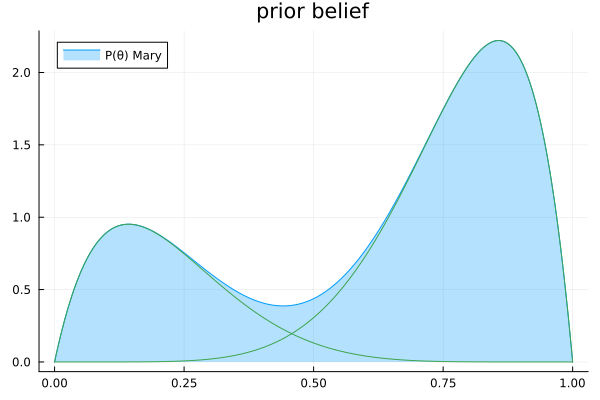

In [9]:
rθ = range(0, 1, length = 1000)
p = plot(title = "prior belief")
plot!(rθ, (x) -> pdf(MixtureDistribution([Beta(2.0, 7.0), Beta(7.0, 2.0)], [ 0.3, 0.7 ]), x), fillalpha=0.3, fillrange = 0, label="P(θ) Mary", c=1)
plot!(rθ, (x) -> 0.7*pdf(Beta(7.0, 2.0), x), c=3, label="")
plot!(rθ, (x) -> 0.3*pdf(Beta(2.0, 7.0), x), c=3, label="")

She was also interested in the results and used the new [`Mixture`](https://github.com/reactivebayes/ReactiveMP.jl/blob/master/src/nodes/mixture.jl) node and addons in `ReactiveMP.jl`. She specified her model as follows and performed inference in this model:

In [10]:
@model function beta_model_mary(y)

    # specify John's and Jane's prior models over θ
    θ_jane ~ Beta(2.0, 7.0)
    θ_john ~ Beta(7.0, 2.0)

    # specify initial guess as to who is right
    john_is_right ~ Bernoulli(0.7) 

    # specify mixture prior Distribution
    θ ~ Mixture(switch = john_is_right, inputs = [θ_jane, θ_john])

    # create likelihood models
    y .~ Bernoulli(θ)
    
end

This [`Mixture`](https://github.com/reactivebayes/ReactiveMP.jl/blob/master/src/nodes/mixture.jl) node updates the belief over $c$ on the performance of the individual models of both John and Jane using so-called scale factors, as introduced in [Nguyen et al.](https://ieeexplore.ieee.org/document/9919250). The specific update rules for this node can be found [here](https://github.com/reactivebayes/ReactiveMP.jl/tree/master/src/rules/mixture).

In [11]:
result_mary = infer(
    model = beta_model_mary(), 
    data  = (y = dataset, ),
    returnvars = (θ = KeepLast(), θ_john = KeepLast(), θ_jane = KeepLast(), john_is_right = KeepLast()),
    addons = AddonLogScale(),
    postprocess = UnpackMarginalPostprocess(),
)

Inference results:
  Posteriors       | available for (john_is_right, θ_john, θ, θ_jane)


Mary was happy, with her mixture prior, she beat John in terms of performance. However, it was not the best decision to think that John was right. In fact, after the experiment there was only a minor possibility remaining that John was right. Her posterior distribution over $\theta$ also changed, and as expected the estimate from Jane was more prominent.

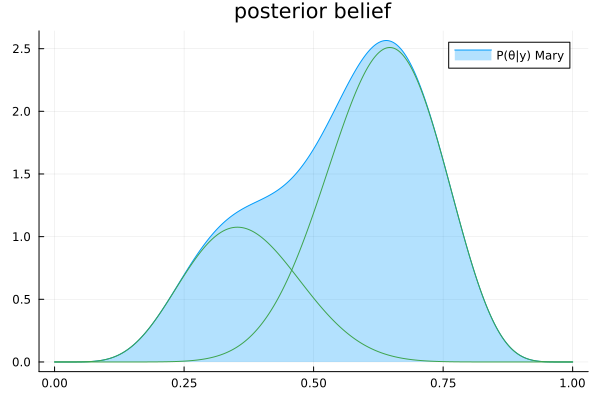

In [12]:
rθ = range(0, 1, length = 1000)
p = plot(title = "posterior belief")
plot!(rθ, (x) -> pdf(result_mary.posteriors[:θ], x), fillalpha=0.3, fillrange = 0, label="P(θ|y) Mary", c=1)
plot!(rθ, (x) -> result_mary.posteriors[:θ].weights[1] * pdf(component(result_mary.posteriors[:θ], 1), x), label="", c=3)
plot!(rθ, (x) -> result_mary.posteriors[:θ].weights[2] * pdf(component(result_mary.posteriors[:θ], 2), x), label="", c=3)